In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


In [93]:
# Load your dataset
df = pd.read_csv('Pharmaceutical Drug Spending by countries.csv')
df

,LOCATION,TIME,PC_HEALTHXP,PC_GDP,USD_CAP,FLAG_CODES,TOTAL_SPEND
0,AUS,1971,15.992,0.727,35.720,NaN,462.11
1,AUS,1972,15.091,0.686,36.056,NaN,475.11
2,AUS,1973,15.117,0.681,39.871,NaN,533.47
3,AUS,1974,14.771,0.755,47.559,NaN,652.65
4,AUS,1975,11.849,0.682,47.561,NaN,660.76
...,...,...,...,...,...,...,...
1031,USA,2011,11.855,1.939,965.580,NaN,300935.91
1032,USA,2012,11.459,1.874,964.237,NaN,302768.85
1033,USA,2013,11.384,1.858,980.864,NaN,310154.01
1034,USA,2014,11.968,1.981,1081.402,NaN,344495.16


In [94]:
# dropping FLAG_CODES column as it's not relevant to our analysis
df = df.drop(columns="FLAG_CODES")
df

,LOCATION,TIME,PC_HEALTHXP,PC_GDP,USD_CAP,TOTAL_SPEND
0,AUS,1971,15.992,0.727,35.720,462.11
1,AUS,1972,15.091,0.686,36.056,475.11
2,AUS,1973,15.117,0.681,39.871,533.47
3,AUS,1974,14.771,0.755,47.559,652.65
4,AUS,1975,11.849,0.682,47.561,660.76
...,...,...,...,...,...,...
1031,USA,2011,11.855,1.939,965.580,300935.91
1032,USA,2012,11.459,1.874,964.237,302768.85
1033,USA,2013,11.384,1.858,980.864,310154.01
1034,USA,2014,11.968,1.981,1081.402,344495.16


Using Adrienne's code to find the countries with the most amount of data points from 2005-2015 and filling in missing values

In [ ]:
# Create a pivot table with countries as rows and years as columns
pivot_table = df.pivot_table(index='LOCATION', columns='TIME', aggfunc='size', fill_value=0)

# Convert the pivot table to a binary format (presence or absence of observation)
pivot_table = pivot_table.applymap(lambda x: 1 if x > 0 else 0)

# Count the number of observations per country
observation_counts = pivot_table.sum(axis=1)

# Sort the countries by the number of observations
sorted_countries = observation_counts.sort_values(ascending=False).index

# Reorder the pivot table based on the sorted countries
pivot_table_sorted = pivot_table.loc[sorted_countries]
pivot_table_sorted

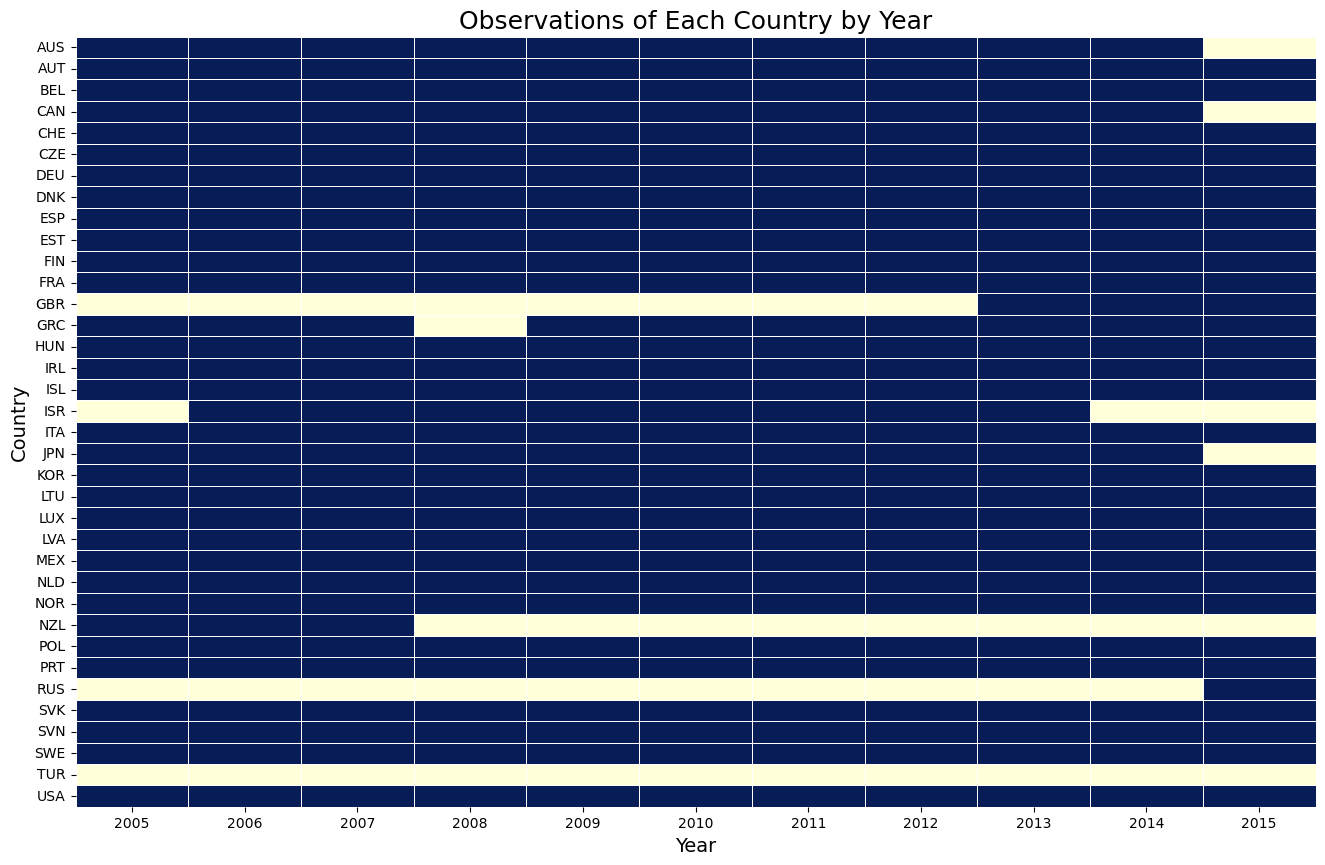

In [ ]:
# Filtering for years 2005 to 2015
pivot_table_filtered = pivot_table.loc[:, 2005:2015]

# Plot the heatmap
plt.figure(figsize=(16, 10))
heatmap = sns.heatmap(pivot_table_filtered, cmap="YlGnBu", cbar=False, linewidths=.5)

# Add labels and title
heatmap.set_xlabel('Year', fontsize=14)
heatmap.set_ylabel('Country', fontsize=14)
heatmap.set_title('Observations of Each Country by Year', fontsize=18)

# Display the heatmap
plt.show()

In [97]:
# Define the years and excluded countries
years = pd.Series(range(2005, 2016), name="TIME")
locations = df["LOCATION"].drop_duplicates()
excluded_countries = ['GBR', 'ISR', 'NZL', 'RUS', 'TUR']
locations = locations[~locations.isin(excluded_countries)]

# Create all combinations of LOCATION and TIME
all_combinations = pd.merge(locations, years, how="cross")

# Merge with the original df to include only existing data
df_decade_complete = pd.merge(
    all_combinations,
    df,
    on=["LOCATION", "TIME"],
    how="left"
)

# Result: All combinations with missing data as NaNs
df_decade_complete

,LOCATION,TIME,PC_HEALTHXP,PC_GDP,USD_CAP,TOTAL_SPEND
0,AUS,2005,15.218,1.213,432.513,8821.02
1,AUS,2006,15.276,1.219,461.821,9558.72
2,AUS,2007,15.201,1.225,485.887,10119.86
3,AUS,2008,15.412,1.273,510.172,10840.75
4,AUS,2009,15.535,1.334,553.724,12011.21
...,...,...,...,...,...,...
336,USA,2011,11.855,1.939,965.580,300935.91
337,USA,2012,11.459,1.874,964.237,302768.85
338,USA,2013,11.384,1.858,980.864,310154.01
339,USA,2014,11.968,1.981,1081.402,344495.16


In [98]:
df_decade_complete['LOCATION'].nunique()

31

In [99]:
# # Summary of missing values
missing_summary = df_decade_complete.isnull().sum()
print(missing_summary[missing_summary > 0])

# Sort by 'LOCATION' and 'TIME' to ensure proper order for forward filling
df_decade_complete = df_decade_complete.sort_values(by=['LOCATION', 'TIME'])
columns_to_fill = ['PC_HEALTHXP', 'PC_GDP', 'USD_CAP', 'TOTAL_SPEND']
df_decade_complete[columns_to_fill] = (
    df_decade_complete.groupby('LOCATION')[columns_to_fill].ffill()
)

PC_HEALTHXP    4
PC_GDP         4
USD_CAP        4
TOTAL_SPEND    4
dtype: int64


In [100]:
# Confirm there are no more missing values
print(df_decade_complete[columns_to_fill].isnull().sum())

PC_HEALTHXP    0
PC_GDP         0
USD_CAP        0
TOTAL_SPEND    0
dtype: int64


In [ ]:
# Export df_decade_complete to a CSV file
#df_decade_complete.to_csv("Pharma_Spending_2005_2015.csv", index=False)

In [101]:
df_decade_complete.corr(numeric_only=True)

,TIME,PC_HEALTHXP,PC_GDP,USD_CAP,TOTAL_SPEND
TIME,1.000000,-0.131324,-0.034922,0.268026,0.046713
PC_HEALTHXP,-0.131324,1.000000,0.752218,-0.263304,-0.121760
PC_GDP,-0.034922,0.752218,1.000000,0.328148,0.274185
USD_CAP,0.268026,-0.263304,0.328148,1.000000,0.579900
TOTAL_SPEND,0.046713,-0.121760,0.274185,0.579900,1.000000


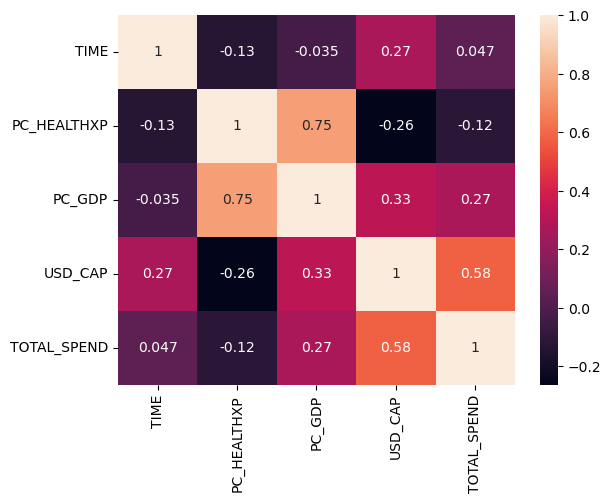

In [102]:
sns.heatmap(df_decade_complete.corr(numeric_only=True), annot=True)
plt.show()

Correlation high between: <br>
USD_CAP & TOTAL_SPEND (0.58) <br>
PC_GDP & PC_HEALTHXP (0.75) 

1. Clustering df_decade_complete with 2 variables (USD_CAP, TOTAL_SPEND)

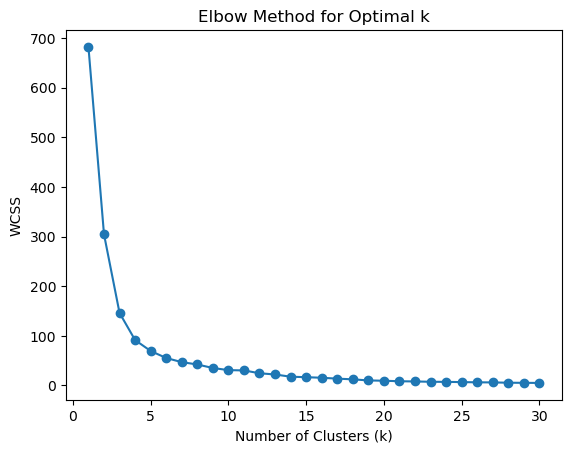

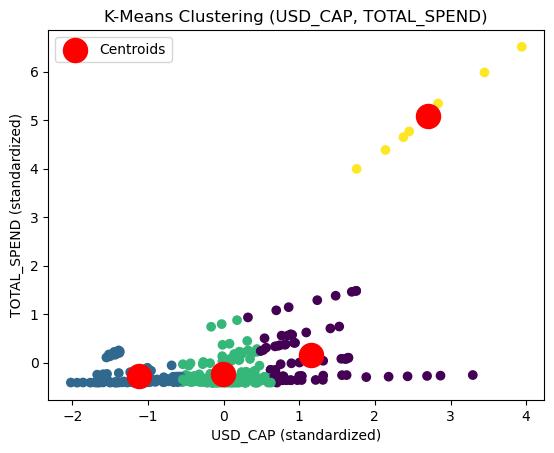

In [170]:
# Select relevant features for clustering
X = df_decade_complete[['USD_CAP', 'TOTAL_SPEND']]

# Step 1: Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Determine the optimal number of clusters using the Elbow Method
wcss = []
for k in range(1, 31): # 31 countries in total
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Create a DataFrame for WCSS values and print
# wcss_df = pd.DataFrame({'Number of Clusters': range(1, 31), 'WCSS': wcss})
# print(wcss_df)

# Plot the WCSS to find the elbow
plt.plot(range(1, 31), wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k')
plt.show()  

# Step 3: Fit K-Means with the chosen number of clusters
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
df_decade_complete['Cluster'] = kmeans.fit_predict(X_scaled)

# Step 4: Interpret and visualize
# Get cluster centroids
centroids = kmeans.cluster_centers_

# Plot clusters in 2D
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=df_decade_complete['Cluster'], cmap='viridis', marker='o')
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='red', label='Centroids')
plt.xlabel('USD_CAP (standardized)')
plt.ylabel('TOTAL_SPEND (standardized)')
plt.title('K-Means Clustering (USD_CAP, TOTAL_SPEND)')
plt.legend()
plt.show()

In [171]:
# Add cluster labels to the DataFrame
df_decade_complete['Cluster'] = kmeans.labels_
df_decade_complete

,LOCATION,TIME,PC_HEALTHXP,PC_GDP,USD_CAP,TOTAL_SPEND,Cluster
0,AUS,2005,15.218,1.213,432.513,8821.02,2
1,AUS,2006,15.276,1.219,461.821,9558.72,2
2,AUS,2007,15.201,1.225,485.887,10119.86,2
3,AUS,2008,15.412,1.273,510.172,10840.75,2
4,AUS,2009,15.535,1.334,553.724,12011.21,2
...,...,...,...,...,...,...,...
336,USA,2011,11.855,1.939,965.580,300935.91,3
337,USA,2012,11.459,1.874,964.237,302768.85,3
338,USA,2013,11.384,1.858,980.864,310154.01,3
339,USA,2014,11.968,1.981,1081.402,344495.16,3


In [ ]:
# # Export df_decade_complete to a CSV file
#df_decade_complete.to_csv("4d_Clustering_2005_2015 (USD_CAP, TOTAL_SPEND).csv", index=False)

In [172]:
print(df_decade_complete.groupby('Cluster')['LOCATION'].count())

Cluster
0     67
1     96
2    167
3     11
Name: LOCATION, dtype: int64


Assigning each country with the majority cluster number before doing further analysis

In [173]:
# Step 1: Compute the majority cluster for each country
majority_clusters = df_decade_complete.groupby('LOCATION')['Cluster'].agg(lambda x: x.mode()[0])

# Step 2: Map the majority cluster to all rows in the original DataFrame
df_decade_complete['Cluster'] = df_decade_complete['LOCATION'].map(majority_clusters)
df_decade_complete


,LOCATION,TIME,PC_HEALTHXP,PC_GDP,USD_CAP,TOTAL_SPEND,Cluster
0,AUS,2005,15.218,1.213,432.513,8821.02,2
1,AUS,2006,15.276,1.219,461.821,9558.72,2
2,AUS,2007,15.201,1.225,485.887,10119.86,2
3,AUS,2008,15.412,1.273,510.172,10840.75,2
4,AUS,2009,15.535,1.334,553.724,12011.21,2
...,...,...,...,...,...,...,...
336,USA,2011,11.855,1.939,965.580,300935.91,3
337,USA,2012,11.459,1.874,964.237,302768.85,3
338,USA,2013,11.384,1.858,980.864,310154.01,3
339,USA,2014,11.968,1.981,1081.402,344495.16,3


In [ ]:
# Create a DataFrame with each country and its majority cluster
country_clusters = df_decade_complete.groupby('LOCATION')['Cluster'].first().reset_index()

# Sort by cluster to group countries by cluster
country_clusters = country_clusters.sort_values(by='Cluster')

# Create a dictionary grouping countries by cluster
cluster_groups = country_clusters.groupby('Cluster')['LOCATION'].apply(list)

# Print the grouped clusters
for cluster, countries in cluster_groups.items():
    print(f"Cluster {cluster}: {', '.join(countries)}")


Cluster 0: JPN, IRL, BEL, CAN, CHE, DEU, GRC, FRA
Cluster 1: POL, LTU, LVA, NOR, DNK, CZE, MEX, EST, NLD
Cluster 2: AUS, SVN, SVK, PRT, ISL, KOR, ITA, SWE, HUN, FIN, ESP, AUT, LUX
Cluster 3: USA


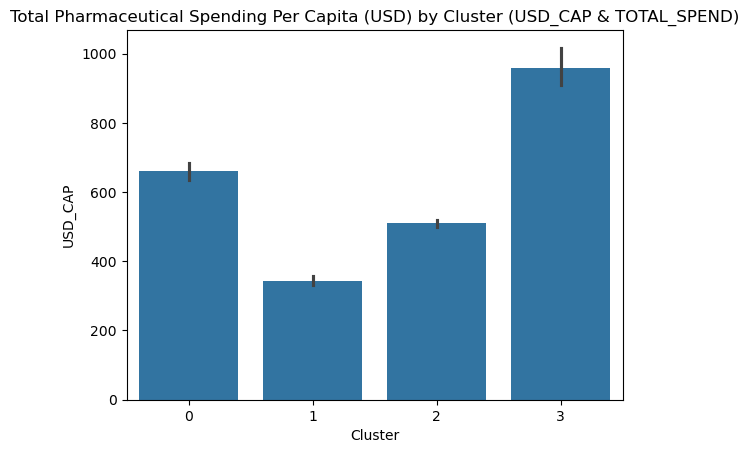

In [174]:
# Bar plot of USD_CAP by cluster
sns.barplot(x='Cluster', y='USD_CAP', data=df_decade_complete)
plt.title('Total Pharmaceutical Spending Per Capita (USD) by Cluster (USD_CAP & TOTAL_SPEND)')
plt.show()

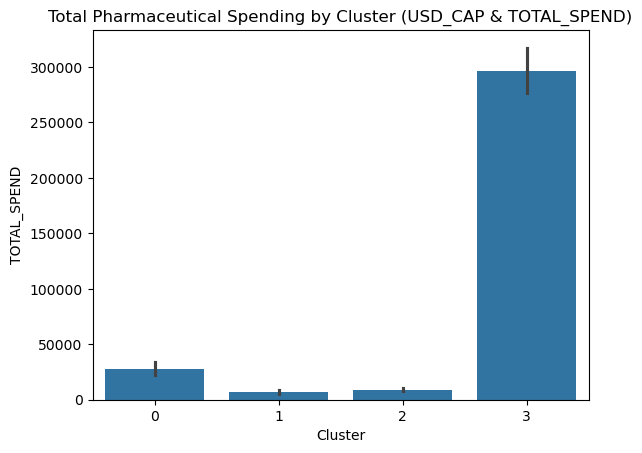

In [175]:
# Bar plot of TOTAL_SPEND by cluster
sns.barplot(x='Cluster', y='TOTAL_SPEND', data=df_decade_complete)
plt.title('Total Pharmaceutical Spending by Cluster (USD_CAP & TOTAL_SPEND)')
plt.show()

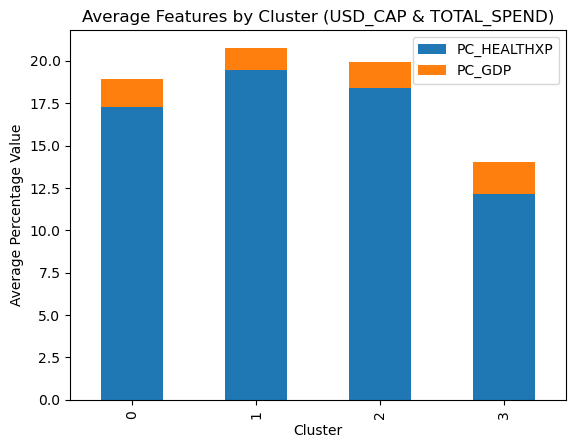

In [176]:
# Group by cluster and calculate the average of the features
avg_features_by_cluster = df_decade_complete.groupby('Cluster')[['PC_HEALTHXP', 'PC_GDP']].mean().reset_index()

# Create a bar plot of the average of PC_HEALTHXP, PC_GDP by Cluster
avg_features_by_cluster.plot(x='Cluster', kind='bar', stacked=True)
plt.title('Average Features by Cluster (USD_CAP & TOTAL_SPEND)')
plt.ylabel('Average Percentage Value')
plt.show()

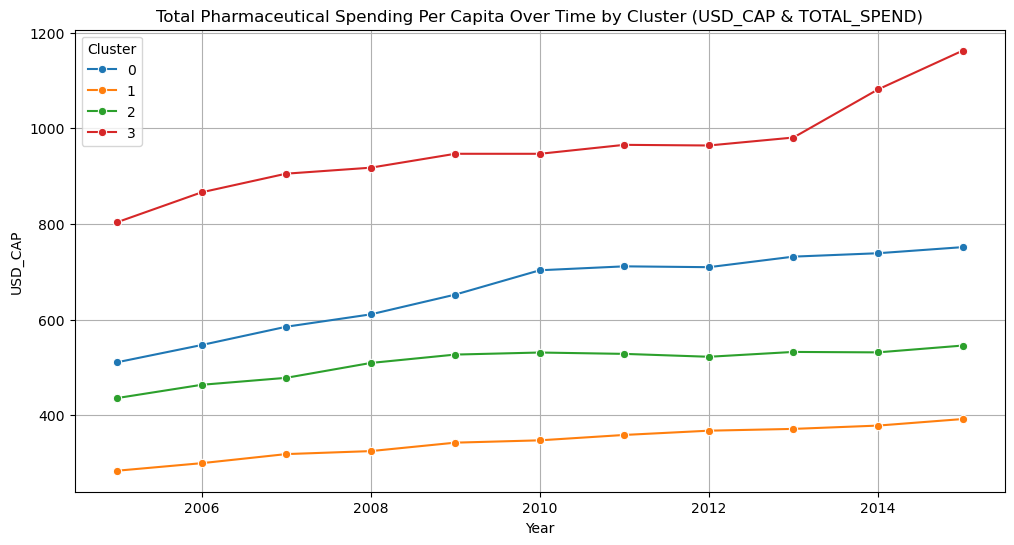

In [177]:
# Group by Cluster and TIME to calculate the mean values over time
cluster_time_trends = df_decade_complete.groupby(['Cluster', 'TIME'])[['PC_HEALTHXP', 'PC_GDP',  'USD_CAP', 'TOTAL_SPEND']].mean().reset_index()

# Line plot for USD_CAP over time by Cluster
plt.figure(figsize=(12, 6))
sns.lineplot(data=cluster_time_trends, x='TIME', y='USD_CAP', hue='Cluster', marker='o', palette='tab10')
plt.title('Total Pharmaceutical Spending Per Capita Over Time by Cluster (USD_CAP & TOTAL_SPEND)')
plt.xlabel('Year')
plt.ylabel('USD_CAP')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

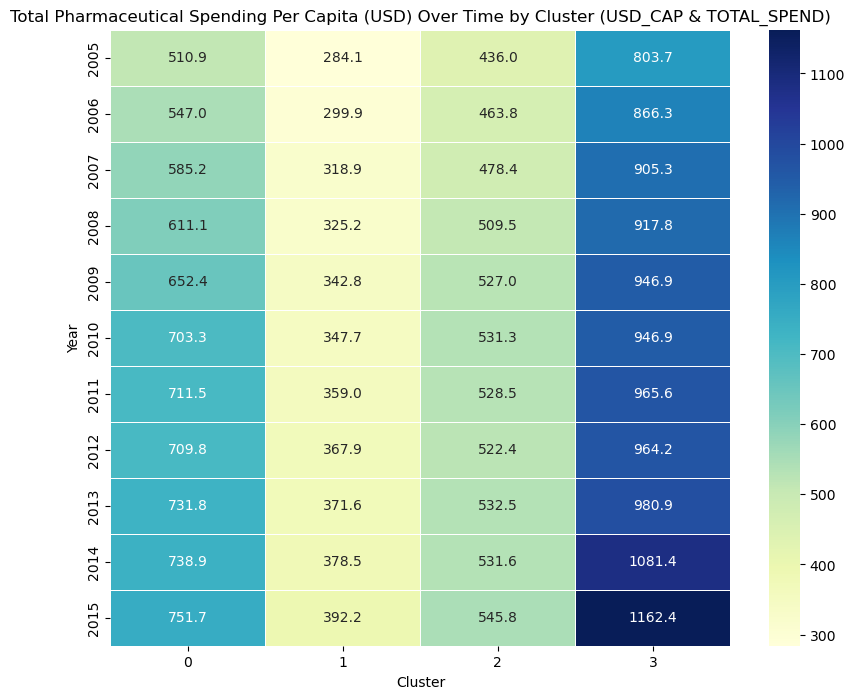

In [178]:
# Pivot the data for a heat map
heatmap_data = cluster_time_trends.pivot(index='TIME', columns='Cluster', values='USD_CAP')

# Plot the heat map
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt=".1f", linewidths=.5)
plt.title('Total Pharmaceutical Spending Per Capita (USD) Over Time by Cluster (USD_CAP & TOTAL_SPEND)')
plt.xlabel('Cluster')
plt.ylabel('Year')
plt.show()

No data points from 2005 were assigned to cluster 0, therefore it's null

2. Clustering df_decade_complete with 2 variables (PC_HEALTHXP, PC_GDP)

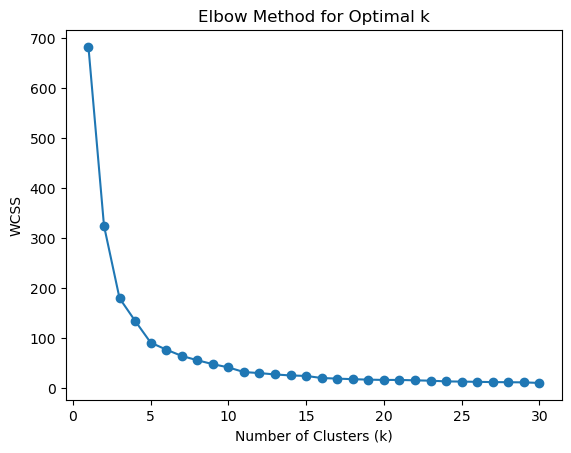

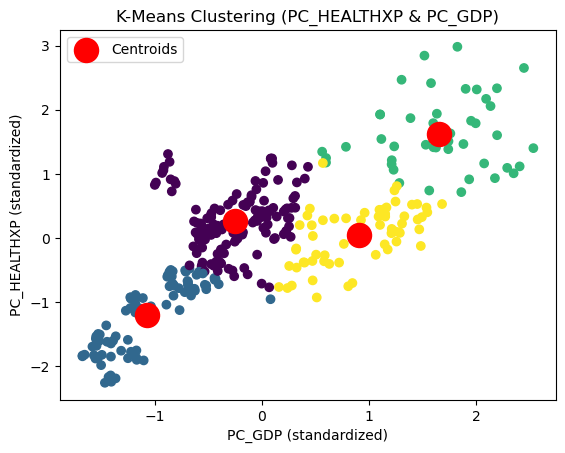

In [189]:
# Select relevant features for clustering
X = df_decade_complete[['PC_HEALTHXP', 'PC_GDP']]

# Step 1: Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Determine the optimal number of clusters using the Elbow Method
wcss = []
for k in range(1, 31): # 31 countries in total
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Create a DataFrame for WCSS values and print
# wcss_df = pd.DataFrame({'Number of Clusters': range(1, 31), 'WCSS': wcss})
# print(wcss_df)

# Plot the WCSS to find the elbow
plt.plot(range(1, 31), wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k')
plt.show()

# Step 3: Fit K-Means with the chosen number of clusters
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
df_decade_complete['Cluster'] = kmeans.fit_predict(X_scaled)

# Step 4: Interpret and visualize
# Get cluster centroids
centroids = kmeans.cluster_centers_

# Plot clusters in 2D
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=df_decade_complete['Cluster'], cmap='viridis', marker='o')
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='red', label='Centroids')
plt.xlabel('PC_GDP (standardized)')
plt.ylabel('PC_HEALTHXP (standardized)')
plt.title('K-Means Clustering (PC_HEALTHXP & PC_GDP)')
plt.legend()
plt.show()

In [190]:
# Add cluster labels to the DataFrame
df_decade_complete['Cluster'] = kmeans.labels_
df_decade_complete

,LOCATION,TIME,PC_HEALTHXP,PC_GDP,USD_CAP,TOTAL_SPEND,Cluster
0,AUS,2005,15.218,1.213,432.513,8821.02,1
1,AUS,2006,15.276,1.219,461.821,9558.72,1
2,AUS,2007,15.201,1.225,485.887,10119.86,1
3,AUS,2008,15.412,1.273,510.172,10840.75,0
4,AUS,2009,15.535,1.334,553.724,12011.21,0
...,...,...,...,...,...,...,...
336,USA,2011,11.855,1.939,965.580,300935.91,0
337,USA,2012,11.459,1.874,964.237,302768.85,0
338,USA,2013,11.384,1.858,980.864,310154.01,0
339,USA,2014,11.968,1.981,1081.402,344495.16,0


In [ ]:
# Export df_decade_complete to a CSV file
# df_decade_complete.to_csv("4e_Clustering_2005_2015 (PC_HEALTHXP, PC_GDP).csv", index=False)

In [191]:
print(df_decade_complete.groupby('Cluster')['LOCATION'].count())

Cluster
0    139
1     92
2     44
3     66
Name: LOCATION, dtype: int64


Assigning each country with the majority cluster number before doing further analysis

In [192]:
# Step 1: Compute the majority cluster for each country
majority_clusters = df_decade_complete.groupby('LOCATION')['Cluster'].agg(lambda x: x.mode()[0])

# Step 2: Map the majority cluster to all rows in the original DataFrame
df_decade_complete['Cluster'] = df_decade_complete['LOCATION'].map(majority_clusters)
df_decade_complete

,LOCATION,TIME,PC_HEALTHXP,PC_GDP,USD_CAP,TOTAL_SPEND,Cluster
0,AUS,2005,15.218,1.213,432.513,8821.02,0
1,AUS,2006,15.276,1.219,461.821,9558.72,0
2,AUS,2007,15.201,1.225,485.887,10119.86,0
3,AUS,2008,15.412,1.273,510.172,10840.75,0
4,AUS,2009,15.535,1.334,553.724,12011.21,0
...,...,...,...,...,...,...,...
336,USA,2011,11.855,1.939,965.580,300935.91,0
337,USA,2012,11.459,1.874,964.237,302768.85,0
338,USA,2013,11.384,1.858,980.864,310154.01,0
339,USA,2014,11.968,1.981,1081.402,344495.16,0


In [193]:
# Create a DataFrame with each country and its majority cluster
country_clusters = df_decade_complete.groupby('LOCATION')['Cluster'].first().reset_index()

# Sort by cluster to group countries by cluster
country_clusters = country_clusters.sort_values(by='Cluster')

# Create a dictionary grouping countries by cluster
cluster_groups = country_clusters.groupby('Cluster')['LOCATION'].apply(list)

# Print the grouped clusters
for cluster, countries in cluster_groups.items():
    print(f"Cluster {cluster}: {', '.join(countries)}")

Cluster 0: AUS, SVN, PRT, JPN, ITA, IRL, FRA, ESP, USA, DEU, CHE, CAN, BEL
Cluster 1: ISL, FIN, AUT, SWE, DNK, LUX, NLD, NOR
Cluster 2: GRC, HUN, SVK, MEX
Cluster 3: EST, LVA, KOR, CZE, POL, LTU


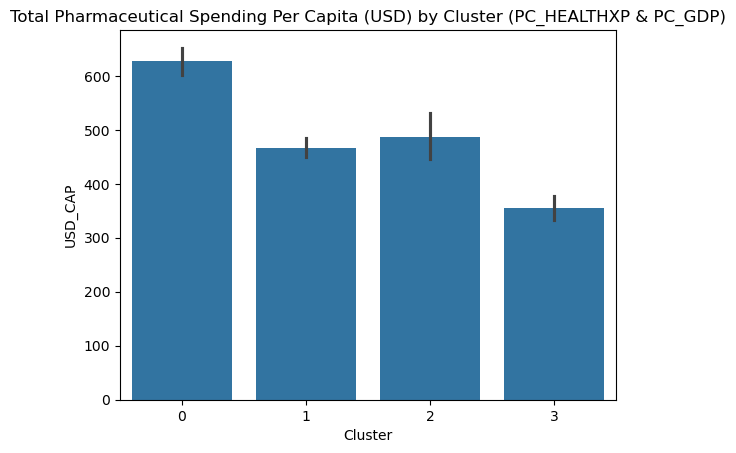

In [194]:
# Bar plot of USD_CAP by cluster
sns.barplot(x='Cluster', y='USD_CAP', data=df_decade_complete)
plt.title('Total Pharmaceutical Spending Per Capita (USD) by Cluster (PC_HEALTHXP & PC_GDP)')
plt.show()

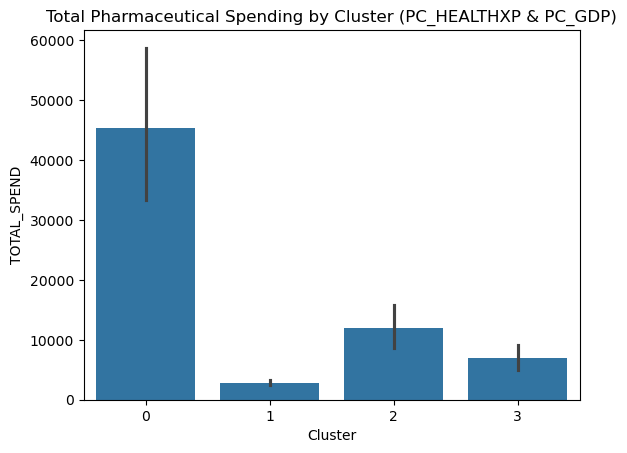

In [195]:
# Bar plot of TOTAL_SPEND by cluster
sns.barplot(x='Cluster', y='TOTAL_SPEND', data=df_decade_complete)
plt.title('Total Pharmaceutical Spending by Cluster (PC_HEALTHXP & PC_GDP)')
plt.show()

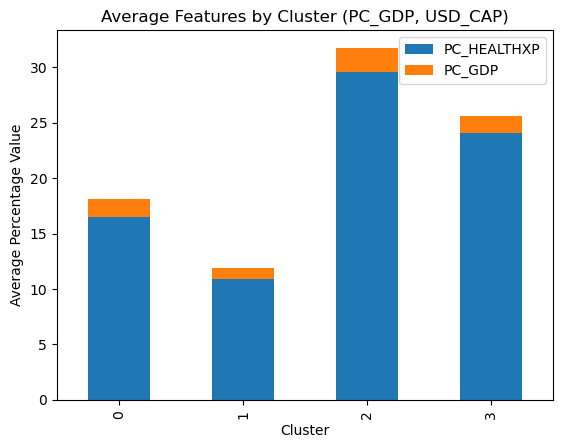

In [196]:
# Group by cluster and calculate the average of the features
avg_features_by_cluster = df_decade_complete.groupby('Cluster')[['PC_HEALTHXP', 'PC_GDP']].mean().reset_index()

# Create a bar plot of the average of PC_HEALTHXP, PC_GDP, USD_CAP by Cluster
avg_features_by_cluster.plot(x='Cluster', kind='bar', stacked=True)
plt.title('Average Features by Cluster (PC_GDP, USD_CAP)')
plt.ylabel('Average Percentage Value')
plt.show()

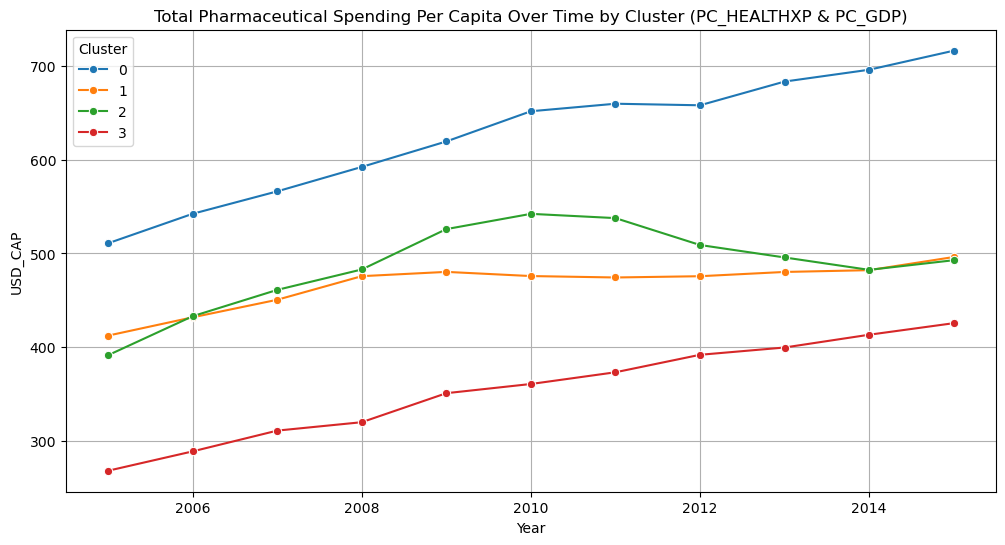

In [197]:
# Group by Cluster and TIME to calculate the mean values over time
cluster_time_trends = df_decade_complete.groupby(['Cluster', 'TIME'])[['PC_HEALTHXP', 'PC_GDP', 'USD_CAP', 'TOTAL_SPEND']].mean().reset_index()

# Line plot for USD_CAP over time by Cluster
plt.figure(figsize=(12, 6))
sns.lineplot(data=cluster_time_trends, x='TIME', y='USD_CAP', hue='Cluster', marker='o', palette='tab10')
plt.title('Total Pharmaceutical Spending Per Capita Over Time by Cluster (PC_HEALTHXP & PC_GDP)')
plt.xlabel('Year')
plt.ylabel('USD_CAP')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

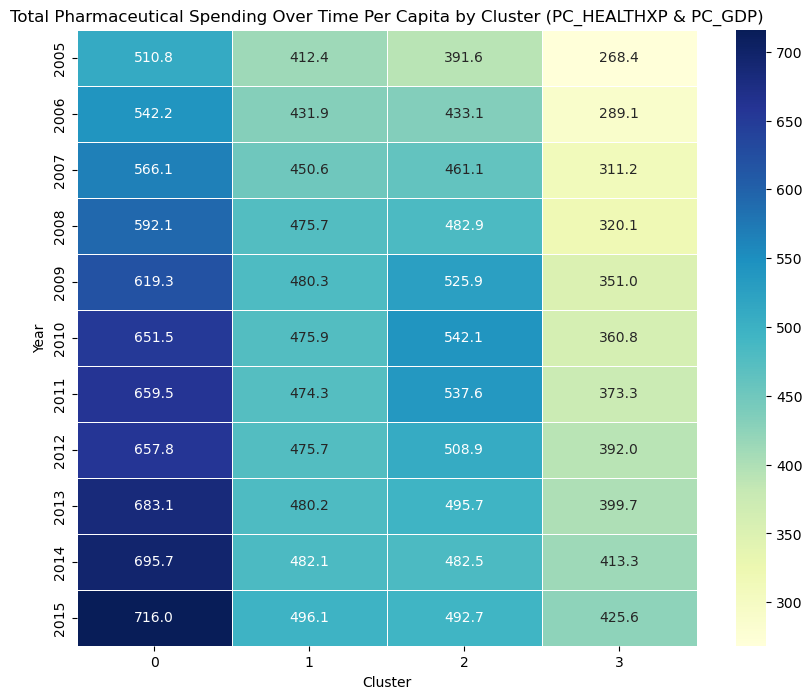

In [198]:
# Pivot the data for a heat map
heatmap_data = cluster_time_trends.pivot(index='TIME', columns='Cluster', values='USD_CAP')

# Plot the heat map
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt=".1f", linewidths=.5)
plt.title('Total Pharmaceutical Spending Over Time Per Capita by Cluster (PC_HEALTHXP & PC_GDP)')
plt.xlabel('Cluster')
plt.ylabel('Year')
plt.show()